In [1]:
import sys
import time
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from airlines_utils import second2date, date2second

def flushPrint(variable):
    sys.stdout.write('\r')
    sys.stdout.write("Processing {:.0f}%".format(variable*100))
    sys.stdout.flush()

In [2]:
departures = pd.read_csv("departures_v2.csv", sep=None, engine='python')

注：构建网络用到的关键信息
- flight_origin_name: 航班出发的机场
- flight_departure_real: 实际出发实际（time in seconds since 1970-01-01 00:00， 下同）
- flight_origin_code_iata: 
- flight_origin_code_icao: 


- flight_destination_name: 到达的机场
- flight_arrival_read: 实际到达时间
- flight_origin_code_icao: 
- flight_destination_code_icao: 

In [3]:
NetDataOri_departures = departures.loc[:, ["flight_origin_name", "flight_destination_name", "flight_departure_real", 
                                           "flight_arrival_real", "flight_origin_code_iata","flight_origin_code_icao",
                                           "flight_destination_code_iata", "flight_destination_code_icao"]]

In [4]:
# 删除出发日期在2019年之前的数据, 实际上这都是五月份的数据
init_data = date2second(2019, 5, 1)
NetData = NetDataOri_departures[NetDataOri_departures.flight_departure_real>=init_data]
print("删除后数据条数：",  len(NetData))

删除后数据条数： 268871


In [5]:
time_early, time_late = min(list(NetData["flight_departure_real"])), max(list(NetData["flight_departure_real"]))

In [6]:
print("数据的时间区间:{} --- {}".format(second2date(time_early), second2date(time_late)))

数据的时间区间:2019-05-19 04:19:50 --- 2019-06-07 14:14:11


In [7]:
origin_code_icao = list(NetData["flight_origin_code_icao"])
destination_code_icao = list(NetData["flight_destination_code_icao"])

# 机场 --> 国家

In [8]:
airports_codes = pd.read_json("airports.json")

In [9]:
countries = airports_codes.loc["country", :].tolist()
icao_codes = airports_codes.loc["icao", :].tolist()

In [10]:
codes_cty_map = {code: cty for cty, code in zip(countries, icao_codes)}

In [11]:
OOD = []
origin = []
for code in origin_code_icao:
    cty = codes_cty_map.get(code, None)
    if cty == None:
        OOD.append(code)
    origin.append(cty)

destination = []
for code in destination_code_icao:
    cty = codes_cty_map.get(code, None)
    if cty == None:
        OOD.append(code)
    destination.append(cty)

In [12]:
print("没有对应国家的机场数：{}".format(len(set(OOD))))
print("ICAO codes:", len(OOD), set(OOD))

没有对应国家的机场数：8
ICAO codes: 1579 {'LTFM', 'GQNO', 'YBSU', 'LNMC', 'EPSY', 'OPIS', 'TVSA', 'DTNH'}


In [13]:
all_cty = list(set(origin + destination))
all_cty.remove(None)
CTY_NUM = len(all_cty)

In [14]:
cty_node_map = {cty: i for i, cty in enumerate(all_cty)}
node_cty_map = {i: cty for i, cty in enumerate(all_cty)}

# 建立流量矩阵

In [15]:
cty_cty_mat = np.zeros([CTY_NUM, CTY_NUM])

In [16]:
for ori, des in zip(origin, destination):
    if ori not in all_cty or des not in all_cty:
        continue
    else:
        ori_node = cty_node_map[ori]
        des_node = cty_node_map[des]
        cty_cty_mat[ori_node, des_node] += 1

# 归一化流量

In [17]:
flow_sum = np.sum(cty_cty_mat, axis=1)

flow = []
for row, summa in zip(cty_cty_mat, flow_sum):
    assert row.sum() == summa
    if summa == 0:
        flow.append(np.array([0] * CTY_NUM))
    else:
        flow.append(row / summa)
        
flow = np.array(flow)

# 计算有效距离

In [18]:
def my_matrix_production(matrix, matrix1):
    #特殊的矩阵乘积，将加法转换为取大
    assert matrix.shape == matrix1.shape
    sz = matrix.shape[0]
    output = np.zeros_like(matrix)
    
    for i in range(sz):
        row = matrix[i, :].reshape(sz, -1)
        output[i, :] = np.amax(row * matrix1, axis=0)
    return output


def eff_distance(prob):
    #输入迁移概率矩阵，计算有效距离
    sz = prob.shape[0]
    prod = prob
    distance = np.ones_like(prob) - np.log(prod)
    
    for i in range(1, sz-1):
        #flushPrint(i / sz)
        prod = my_matrix_production(prod, prob)
        dist = i + 1 - np.log(prod)
        distance = np.minimum(distance, dist)
    return distance

In [19]:
dist = eff_distance(flow)

/Users/philip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/philip/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


# 与中国的有效距离排序

In [20]:
To_China_dist = np.sort(dist[cty_node_map["CN"]])
To_China_name = [node_cty_map[node] for node in np.argsort(dist[cty_node_map["CN"]])]

In [21]:
ISO2 = pd.read_json("2_codes_country.json")
Iso2Name = {code:name for code, name in zip(ISO2.loc["iso2", :].tolist(), ISO2.loc["name", :].tolist())}

In [22]:
print("{:^20} {}".format("国家", "有效距离"))
for d, n in zip(To_China_dist, To_China_name):
    try:
        print("{:^20} | {:.2f}".format(Iso2Name[n], d))
    except:
        print(n)

         国家          有效距离
   United States     | 1.88
      Germany        | 2.80
   United Kingdom    | 2.89
       France        | 2.92
     Australia       | 3.12
       Spain         | 5.70
       Greece        | 6.41
       Italy         | 6.66
       Canada        | 6.71
       Mexico        | 7.07
      Ireland        | 7.23
    Netherlands      | 7.37
    New Zealand      | 7.46
      Portugal       | 7.55
    Switzerland      | 7.66
      Austria        | 7.66
       Poland        | 7.69
      Morocco        | 7.92
 Dominican Republic  | 7.92
       China         | 8.12
      Algeria        | 8.18
      Denmark        | 8.21
      Colombia       | 8.27
 Russian Federation  | 8.28
       Turkey        | 8.32
      Romania        | 8.38
       Sweden        | 8.39
        Cuba         | 8.46
      Croatia        | 8.48
      Bahamas        | 8.49
      Tunisia        | 8.52
       Norway        | 8.55
       Japan         | 8.57
    Puerto Rico      | 8.60
      Hungary        |

# 海外首感

In [23]:
outsea = pd.read_excel("outsea.xlsx")

In [24]:
country_date = {c:d for c, d in zip(outsea.Name.tolist(), outsea.Date.tolist())}
country_dist = {c:d for c, d in zip([Iso2Name.get(n, None) for n in To_China_name], To_China_dist)}

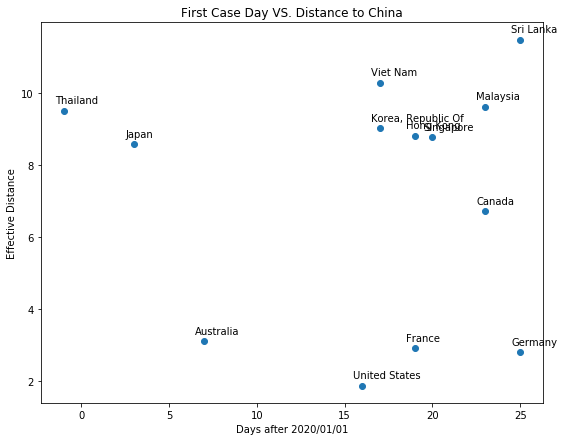

In [26]:
xx, yy, name = [], [], []
for c in country_date.keys():
    try:
        yy.append(country_dist[c])
        xx.append(country_date[c])
        name.append(c)
    except:
        continue
        
fig, ax = plt.subplots(figsize=(9, 7))
ax.plot(xx, yy, "o")

for x, y, name in zip(xx, yy, name):
    t = ax.text(x-0.5, y+0.2, name)

ax.set_xlabel("Days after 2020/01/01")
ax.set_ylabel("Effective Distance")
ax.set_title("First Case Day VS. Distance to China")
plt.savefig("re.pdf")

plt.show()